## Sentiment Prediction using Random Forest Classifier & SVM

#### Welcome to the modelling part of the project!

> For quick test of the trained models, please only run the four cells below until you reach the first -**border line**-

In [1]:
import spacy
import sklearn
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.dummy import DummyClassifier

# Load pre-processed data
df = pd.read_csv("data/all_cleaned_alt")
df.sample(3)

,stars,title,text,text_clean,sentiment,text_sid_vader_neg,text_sid_vader_neu,text_sid_vader_pos,text_sid_vader_compound,text_sid_textblob_polarity
2012,1,It’s probably just me,"It’s probably just me, but I have yet to figur...",it’ probabl just me but i have yet to figur ou...,negative,0.104,0.896,0.000,-0.5267,0.500000
1141,2,Resetting Password - Get ready to know your bl...,42 minutes later i was able to get logged back...,42 minut later i was abl to get log back into ...,negative,0.000,0.937,0.063,0.4497,0.119481
1308,5,Iranian tyrant regime cut off the access of 85...,as you may knowwe are under heaviest internet ...,as you may knoww are under heaviest internet c...,positive,0.044,0.870,0.085,0.3400,0.400000


#### Downloading large spacy model (~700 MB)

In [2]:
%%capture
!python -m spacy download en_core_web_lg

#### Tokenizing, cleaning and vectorizing data with spaCy (1-2 mins)

In [3]:
# defining the spaCy pipeline
nlp = spacy.load("en_core_web_lg")

def clean_text(text):
    doc = nlp(text)
    tokens = [
                token.lemma_.lower() for token in doc if
                token.is_stop == False and
                token.is_oov == False and
                token.is_alpha == True
    ]
    return " ".join(tokens)

def vectorize_text(text):
    doc = nlp(text)
    return doc.vector

#### Load the trained models and test them

In [4]:
rf_trained = joblib.load("trained_models/rf_trained.pkl")
svm_trained = joblib.load("trained_models/svm_trained.pkl")

test_input = input("Enter your review: ")
test_review_vector = vectorize_text(clean_text(test_input)).reshape(1, -1)

prediction_rf = rf_trained.predict(test_review_vector)
prediction_svm = svm_trained.predict(test_review_vector)

print("Review: "+test_input+"\n")
print("RF model sentiment prediction: ", prediction_rf)
print("SVM model sentiment prediction: ", prediction_svm)

Review: It's would be great if to be able to a list view in the library. I like to collect lots of different artists, now it's hard for me to navigate it. Also, some times I need quick access to lyrics of the current song, but how I can see, in current time, is not able. I think I would stay with Apple Music.

RF model sentiment prediction:  ['neutral']
SVM model sentiment prediction:  ['neutral']


---

> If you wish to train the models yourself and evaluate their performance after, feel free to run the rest of the cells until you reach the second -**border line**-

In [ ]:
# applying the new pre-processing pipeline to the data
df["text_clean_alt"] = df["text"].apply(clean_text)
df["text_vector"] = df["text_clean_alt"].apply(vectorize_text)
df.head()

#### Quick class size check

In [381]:
df["sentiment"].value_counts(normalize=True)

negative    0.333333
positive    0.333333
neutral     0.333333
Name: sentiment, dtype: float64

#### Training models and evaluating them (Random Forest Classifier & Support Vector Machine)

In [444]:
# Features & Target
X = df["text_vector"].tolist()
Y = df["sentiment"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [527]:
# Fit & predict 
rf_clf = RandomForestClassifier(random_state=19)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Classification metrics
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

    negative       0.74      0.79      0.76       243
     neutral       0.74      0.72      0.73       227
    positive       0.91      0.87      0.89       252

    accuracy                           0.80       722
   macro avg       0.79      0.79      0.79       722
weighted avg       0.80      0.80      0.80       722



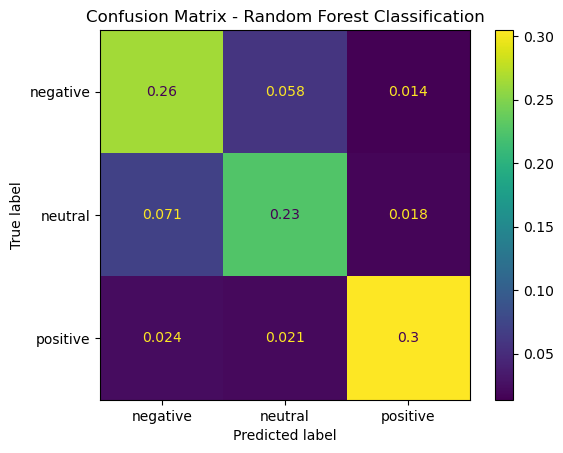

In [535]:
# Confusion matrix of the Random Forest Classification model
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, normalize="all")
plt.title("Confusion Matrix - Random Forest Classification")
plt.show()

In [533]:
# Fit & predict
svm_clf = SVC(
    C=90.2272283049515, 
    degree=2, 
    gamma="auto", 
    kernel="rbf", 
    class_weight="balanced", 
    random_state=105)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

# Classification metrics
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

    negative       0.75      0.81      0.78       243
     neutral       0.76      0.72      0.74       227
    positive       0.93      0.91      0.92       252

    accuracy                           0.82       722
   macro avg       0.81      0.81      0.81       722
weighted avg       0.82      0.82      0.82       722



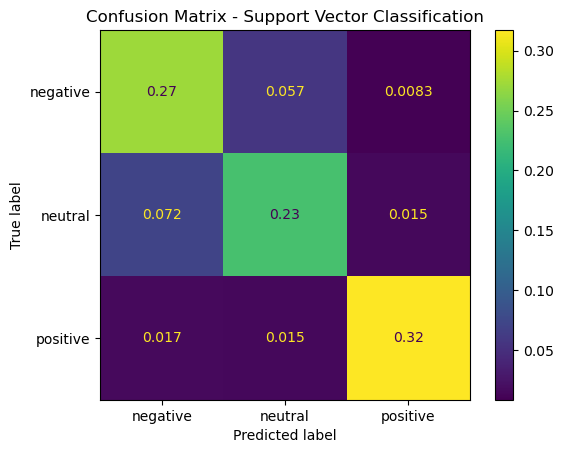

In [534]:
# Confusion matrix of the SVM model
ConfusionMatrixDisplay.from_estimator(svm_clf, X_test, y_test, normalize="all")
plt.title("Confusion Matrix - Support Vector Classification")
plt.show()

In [536]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

# Calculate the accuracy for the dummy and both models
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Dummy accuracy:", accuracy_dummy)
print("Random Forest accuracy:", accuracy_rf)
print("Support Vector Machine accuracy:", accuracy_svm)

Dummy accuracy: 0.314404432132964
Random Forest accuracy: 0.7950138504155124
Support Vector Machine accuracy: 0.8157894736842105


---

#### Export the trained models

In [537]:
joblib.dump(rf_clf, "trained_models/rf_trained.pkl")
joblib.dump(svm_clf, "trained_models/svm_trained.pkl")

['trained_models/svm_trained.pkl']

#### Hyperparameter tuning (Random Forest Classifier)

In [443]:
# Tuning model using RandomizedSearchCV
param_dist = {
            "n_estimators": randint(50, 300),
            "max_depth": randint(2, 8),
            "min_samples_split": randint(2, 6),
            "min_samples_leaf": randint(1, 4),
            "max_features": ["auto", "sqrt", "log2"],
            "bootstrap": [True, False]
}

random_search = RandomizedSearchCV(
    rf_clf, 
    param_distributions=param_dist, 
    n_iter=50, 
    cv=5)
random_search.fit(X_train, y_train)

print("Best hyperparameters: ", random_search.best_params_)


Best hyperparameters:  {'bootstrap': True, 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 120}


In [260]:
# Tuning model using GridSearchCV
param_grid = {
            "n_estimators": [121],
            "max_depth": [7],
            "min_samples_split": [5],
            "min_samples_leaf": [3],
            "max_features": ["auto", "sqrt", "log2"],
            "bootstrap": [True, False]
}
              
grid_search = GridSearchCV(rf_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'bootstrap': False, 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 121}


#### Hyperparameter tuning (Support Vector Machine)

In [442]:
# Tuning model using RandomizedSearchCV
param_dist = {
            "C": uniform(0, 100), 
            "kernel": ["linear", "rbf", "poly"], 
            "degree": range(2, 6), 
            "gamma": ["scale", "auto"],
            "class_weight": ["balanced", None],
            "random_state": [1, 42, 100, None]
}

random_search = RandomizedSearchCV(
    svm_clf, 
    param_distributions=param_dist, 
    n_iter=50, 
    cv=5)
random_search.fit(X_train, y_train)

print("Best hyperparameters: ", random_search.best_params_)

Best hyperparameters:  {'C': 90.2272283049515, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 100}


In [271]:
# Tuning model using GridSearchCV
param_grid = {
            "C": [10, 30, 50, 70, 90],
            "kernel": ["rbf"],
            "degree": [2],
            "gamma": ["scale"],
            "class_weight": ["balanced", None],
            "random_state": [1, 42, 100, None]
}
              
grid_search = GridSearchCV(svm_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 1}


#### Pre-processing pipeline testing

In [422]:
# Checking text pre-processing and vectorization on example reviews
test_review = "I can't believe I have wasted !!! so much money 123 on VPN. Very bad $$ service. Never again."

test_clean = clean_text(test_review)
print(test_clean)

vector = vectorize_text(test_clean).reshape(1, -1)
print(vector.shape)

# Feel free to take one of these reviews for testing
# ---
# I have 3 ALexas at home!! Get very good soon what love all of them amazing stuff! \U0001F600-\U0001F64F amazon.com
# I can't believe I have wasted !!! so much money 123 on VPN. Very bad $$ service. Never again.
# I absolutely *** hate Apple! Their customer support is the worst!
# I absolutely $$ the at a love Google!!1 They wadawd 123 3124 $$ are the best!
# 

believe waste money vpn bad service
(1, 300)
